# Classifying loan repayment

This notebook focuses on classifying loan repayment using various machine learning techniques. The goal is to predict whether a customer will subscribe to a term deposit based on their personal and banking information. The project involves data loading, exploratory data analysis, feature engineering, model training with Gradient Boosting Classifier and MLP Classifier, and finally, deploying a prediction interface using Gradio.

### Data Loading and Initial Exploration

These cells are responsible for:

*   **Loading Data**: Importing `pandas` and `numpy`, then loading `train.csv` and `test.csv` into DataFrames `df` and `df_test` respectively.
*   **Initial Inspection**: Displaying the first few rows of the training data (`df.head()`) to get a quick overview of its structure and content.
*   **Data Information**: Using `df.info()` to check data types, non-null counts, and memory usage, which is crucial for identifying missing values and understanding column types.
*   **Target Imbalance Check**: Examining the distribution of the target variable `'y'` using `df['y'].value_counts()` to identify potential class imbalance, which is important for model selection and evaluation.

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


In [ ]:
# Imbalanced target values
df['y'].value_counts()

,count
y,
0,659512
1,90488


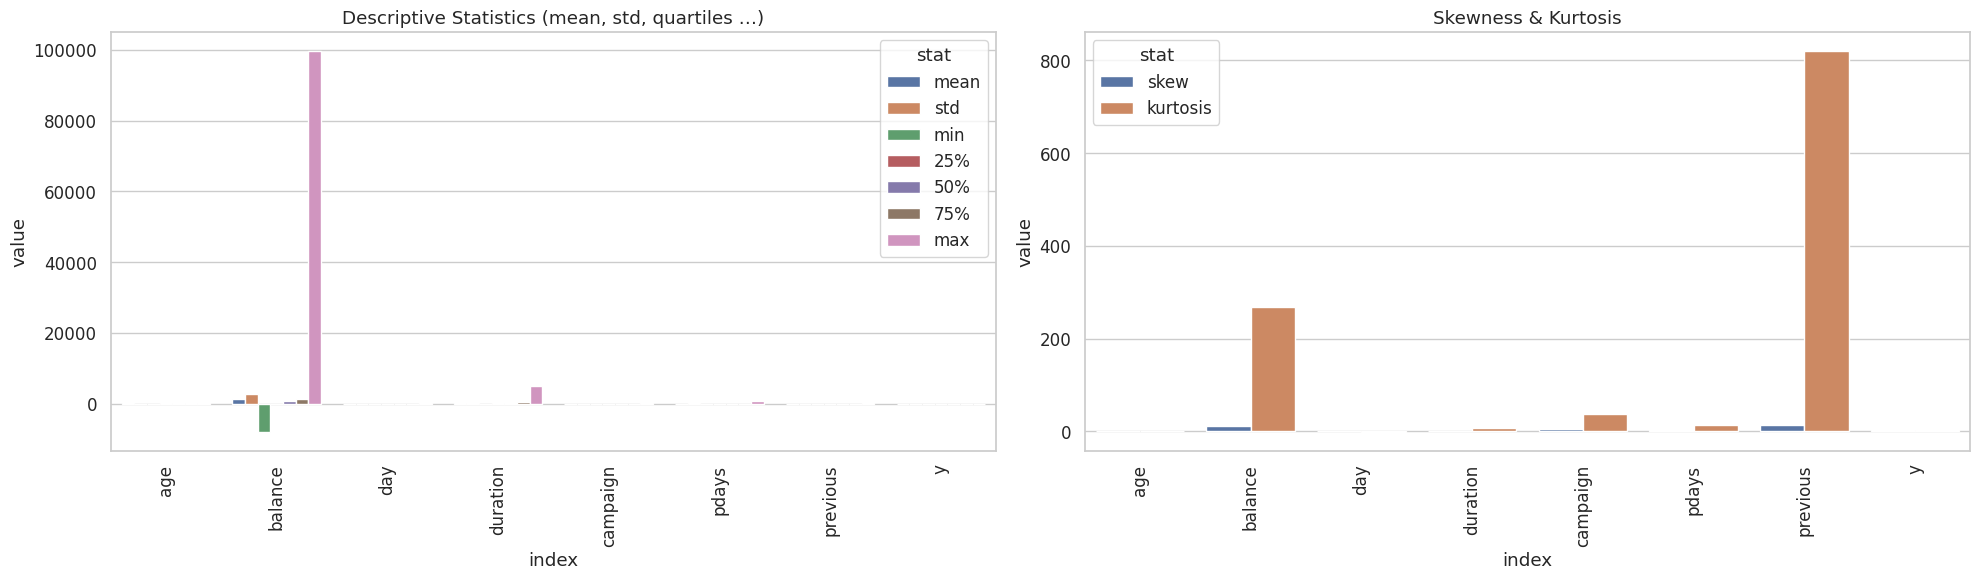

In [ ]:
df_copy = pd.read_csv('train.csv')
sns.set(style='whitegrid', font_scale=1.1)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
desc = df[num_cols].describe().T
desc['skew'] = df[num_cols].skew()
desc['kurtosis'] = df[num_cols].kurtosis()

plot_cols = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis']
plot_df = desc[plot_cols].reset_index().melt(id_vars='index', var_name='stat', value_name='value')

fig, ax = plt.subplots(1, 2, figsize=(20,6))
sns.barplot(data=plot_df[~plot_df['stat'].isin(['skew', 'kurtosis'])], x='index', y='value', hue='stat', ax=ax[0])
ax[0].set_title('Descriptive Statistics (mean, std, quartiles …)')
ax[0].tick_params(axis='x', rotation=90)

skew_kurt = plot_df[plot_df['stat'].isin(['skew', 'kurtosis'])]
sns.barplot(data=skew_kurt, x='index', y='value', hue='stat', ax=ax[1])
ax[1].set_title('Skewness & Kurtosis')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

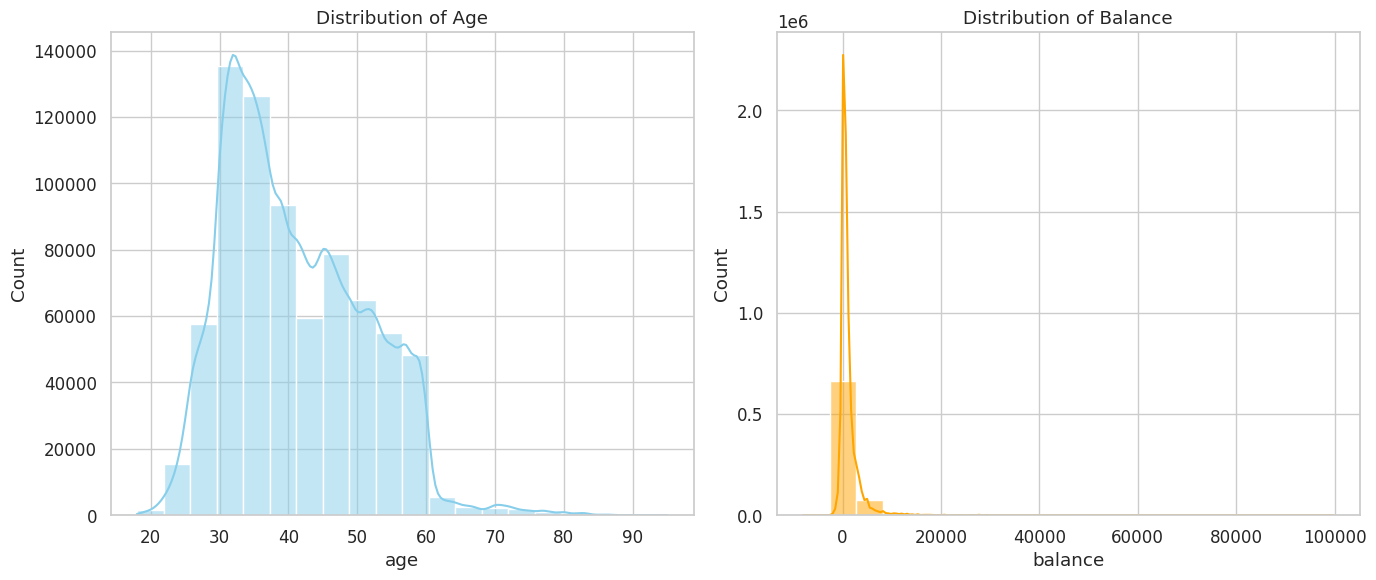

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True, color='skyblue', bins=20)
plt.title('Distribution of Age')


plt.subplot(1, 2, 2)
sns.histplot(df['balance'], kde=True, color='orange', bins=20)
plt.title('Distribution of Balance')

plt.tight_layout()
plt.show()

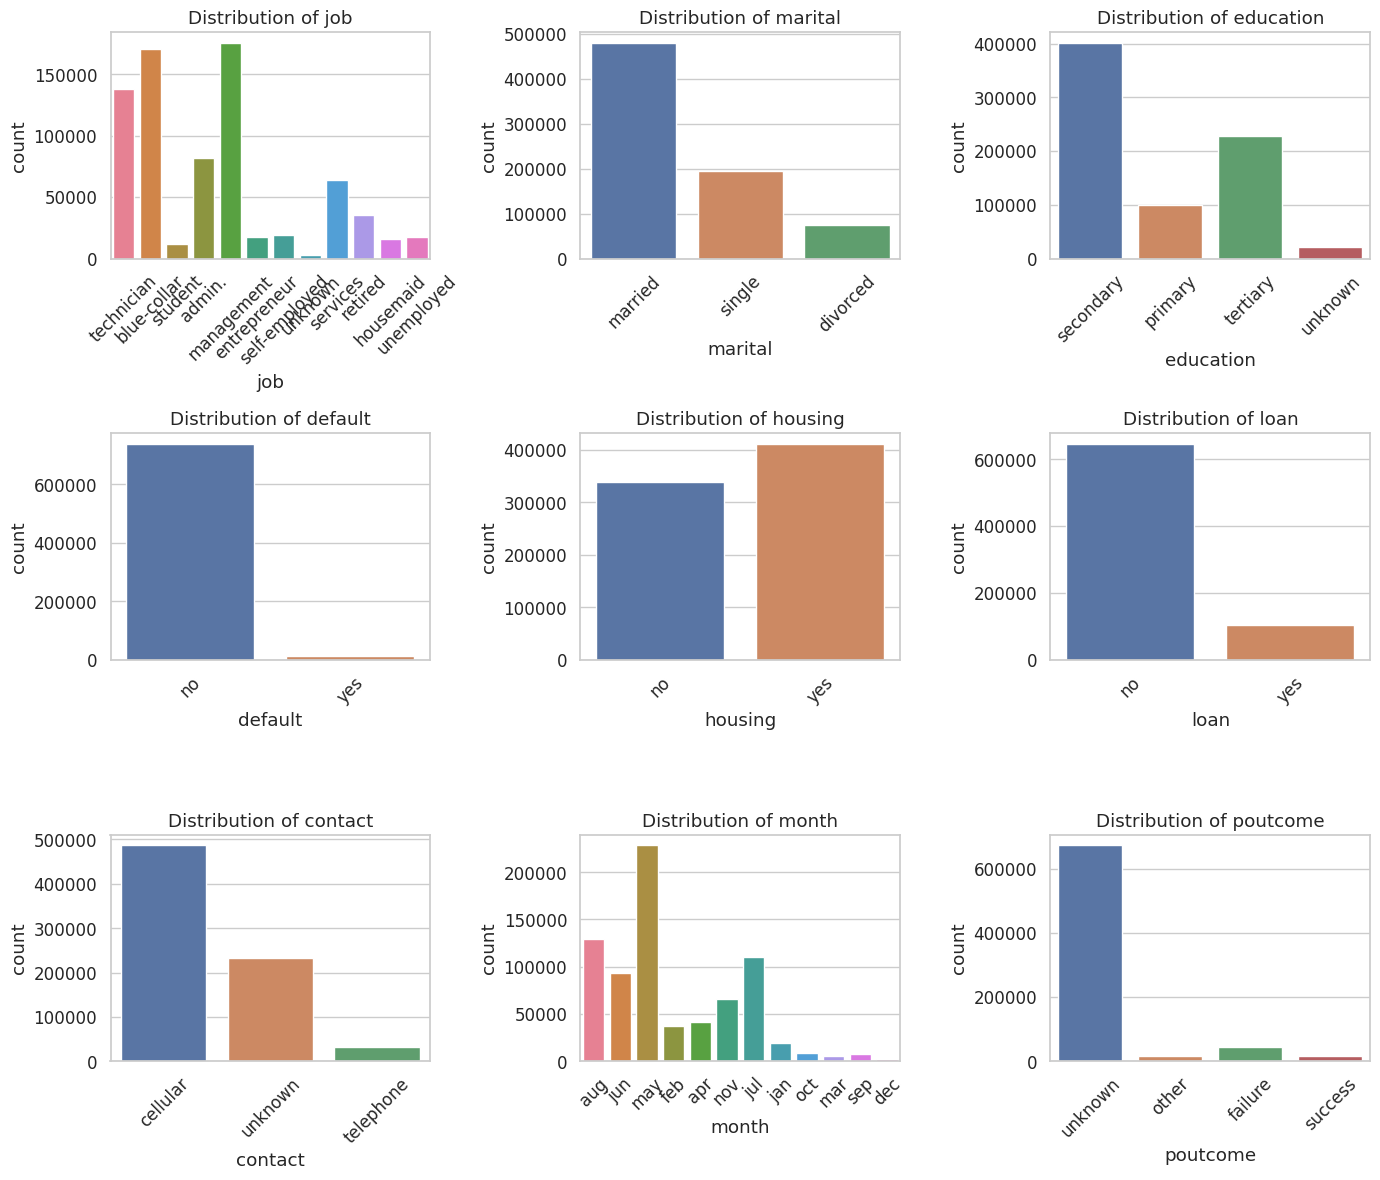

In [ ]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

plt.figure(figsize=(14, 12))
for i, c in enumerate(categorical_columns, 1):
  plt.subplot(3,3,i)
  sns.countplot(x=c, data=df, hue=c, legend=False)
  plt.title(f'Distribution of {c}')
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

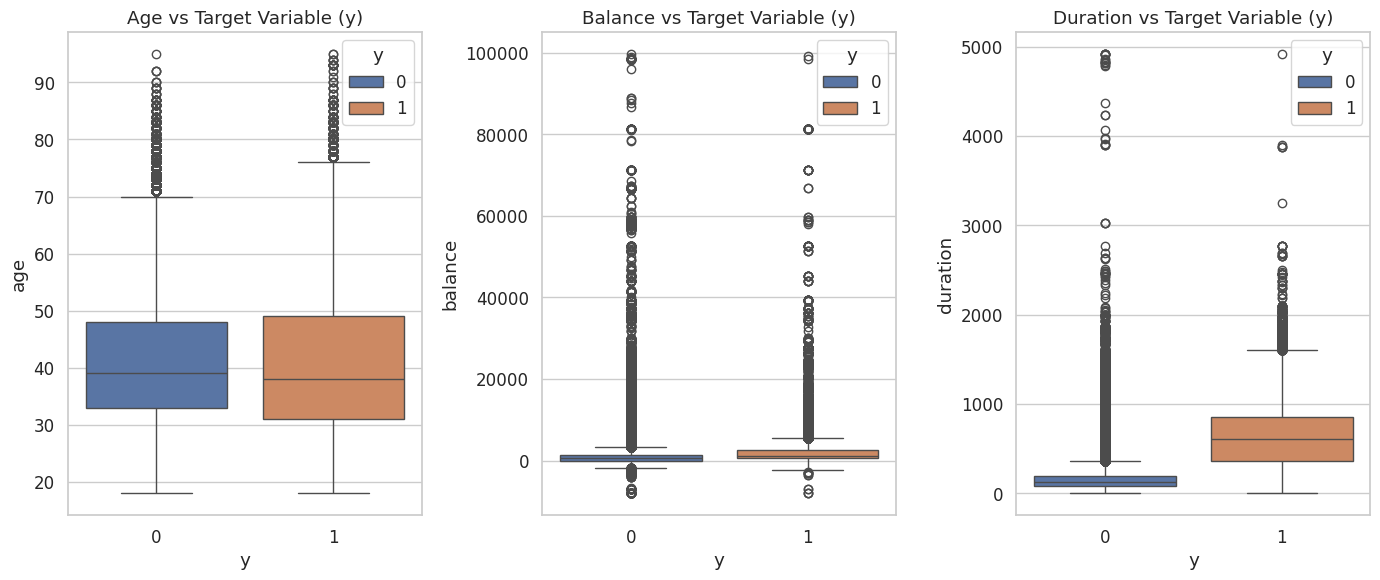

In [ ]:
plt.figure(figsize=(14, 6))


plt.subplot(1, 3, 1)
sns.boxplot(x='y', y='age', data=df, hue='y')
plt.title('Age vs Target Variable (y)')


plt.subplot(1, 3, 2)
sns.boxplot(x='y', y='balance', data=df, hue='y')
plt.title('Balance vs Target Variable (y)')


plt.subplot(1, 3, 3)
sns.boxplot(x='y', y='duration', data=df, hue='y')
plt.title('Duration vs Target Variable (y)')

plt.tight_layout()
plt.show()

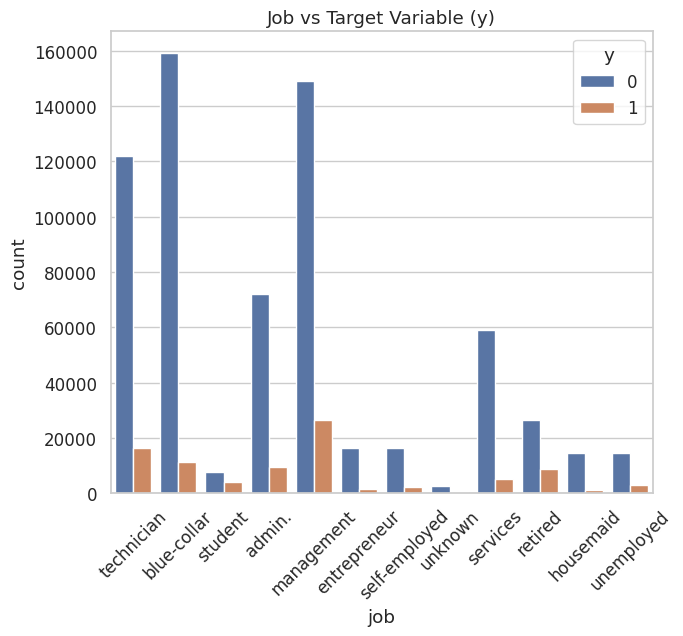

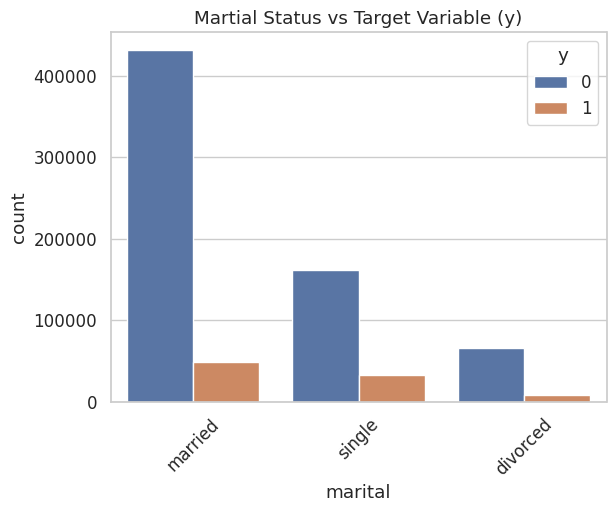

In [ ]:
plt.figure(figsize=(7,6))

sns.countplot(x='job', data=df, hue='y')
plt.title('Job vs Target Variable (y)')
plt.xticks(rotation=45)
plt.show()

sns.countplot(x='marital', data=df, hue='y')
plt.title('Martial Status vs Target Variable (y)')
plt.xticks(rotation=45)
plt.show()

### Feature Engineering

This section introduces new features to improve model performance and capture more complex relationships within the data. The `NEW_FE` function performs the following transformations:

*   **`balance_log`**: Applies a logarithmic transformation (`np.log1p`) to the `balance` column, which helps to normalize its distribution and reduce skewness.
*   **`job_edu`**: Combines `job` and `education` categorical features into a new interaction feature, allowing the model to capture specific job-education combinations.
*   **`contacted_before`**: Creates a binary feature indicating whether a customer was contacted in a previous campaign (`pdays != -1`).
*   **`duration_sin` and `duration_cos`**: Transforms the `duration` feature using sine and cosine functions. This helps tree-based models to better handle the cyclical nature or specific value ranges of `duration` without overfitting to precise thresholds.

In [ ]:
COLS = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome',]

def NEW_FE(df):
  # Making the 'balance' column more equally distributed and have it lose its stark right-skewedness
  df['balance_log'] = np.log1p(df['balance'].clip(lower=0))
  df['job_edu'] = df['job'].astype(str) + "_" + df['education'].astype(str)
  # Convert it into a two value column
  df['contacted_before'] = (df['pdays'] != -1).astype(int)

  # strongly correlated with purchase probability, yet raw values can lead tree models to over-fit by grouping all calls ≥ 400 s into one leaf
  # This mapping provides a soft bin
  df['duration_sin'] = np.sin(2*np.pi * df['duration'] / 800)
  df['duration_cos'] = np.cos(2*np.pi * df['duration'] / 800)

  return df

train = NEW_FE(df)
test = NEW_FE(df_test)

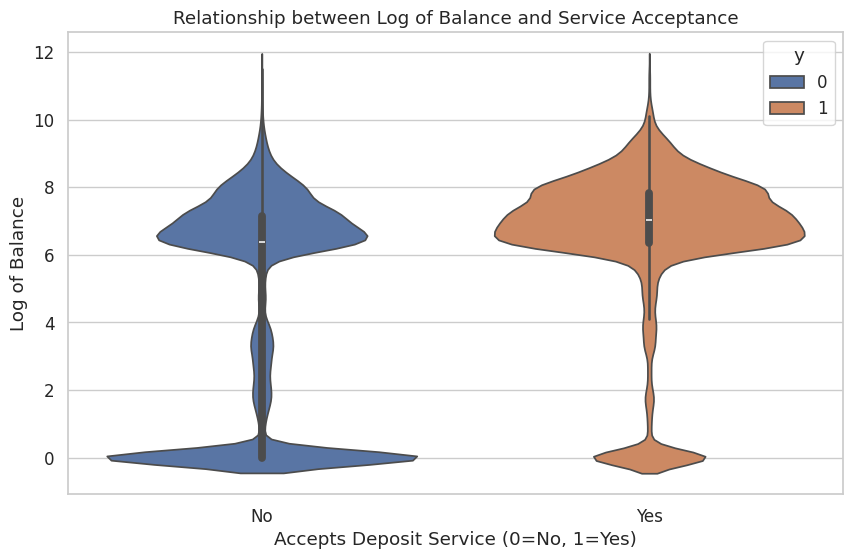

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(data=train, x='y', y='balance_log', hue='y')
plt.title('Relationship between Log of Balance and Service Acceptance')
plt.xlabel('Accepts Deposit Service (0=No, 1=Yes)')
plt.ylabel('Log of Balance')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

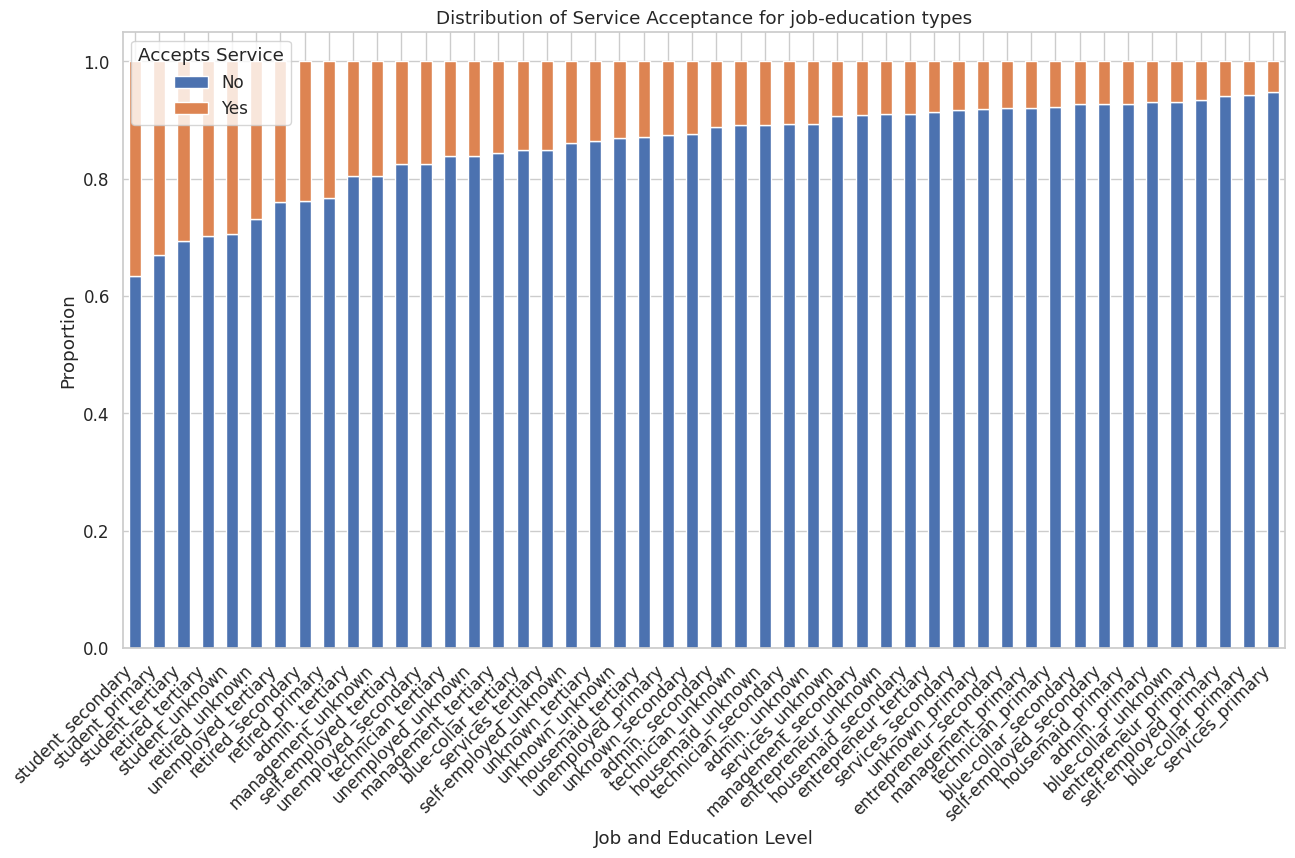

In [ ]:
job_edu_counts = train.groupby('job_edu')['y'].value_counts(normalize=True).unstack().fillna(0)

job_edu_counts = job_edu_counts.sort_values(by=1, ascending=False)

job_edu_counts.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title('Distribution of Service Acceptance for job-education types')
plt.xlabel('Job and Education Level')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accepts Service', labels=['No', 'Yes'])
plt.show()

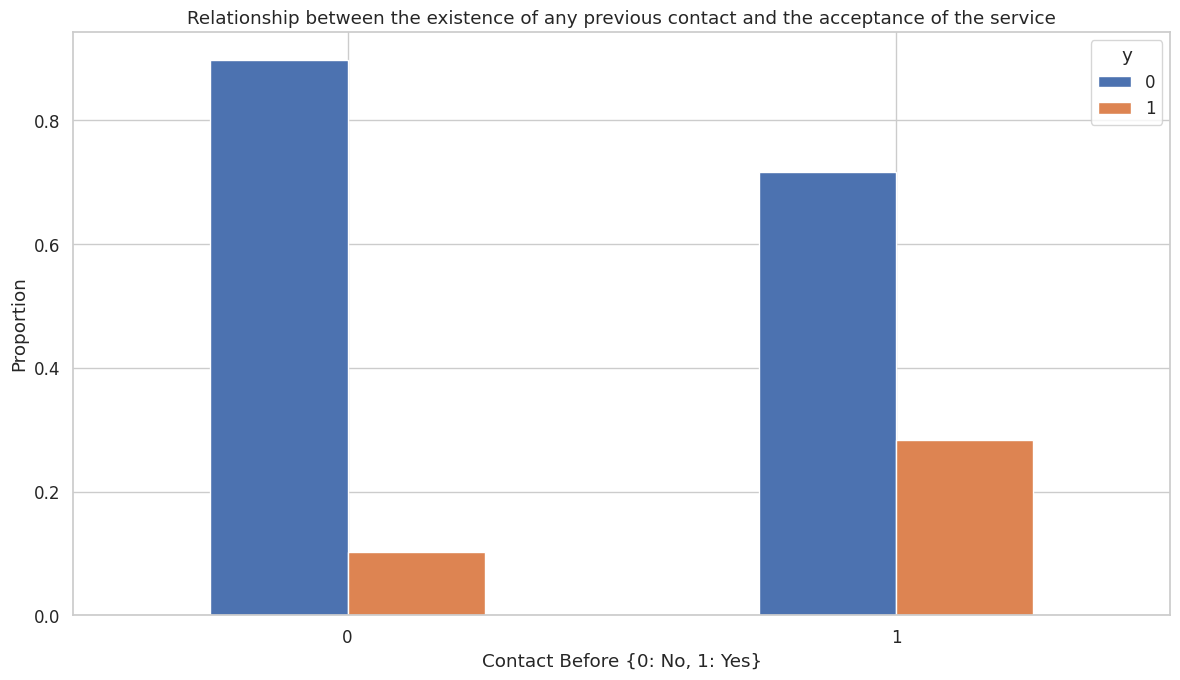

In [ ]:
contact_y_crosstab = pd.crosstab(train['contacted_before'], train['y'], normalize='index')

contact_y_crosstab.plot(kind='bar', figsize=(12,7))
plt.title('Relationship between the existence of any previous contact and the acceptance of the service')
plt.xlabel('Contact Before {0: No, 1: Yes}')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

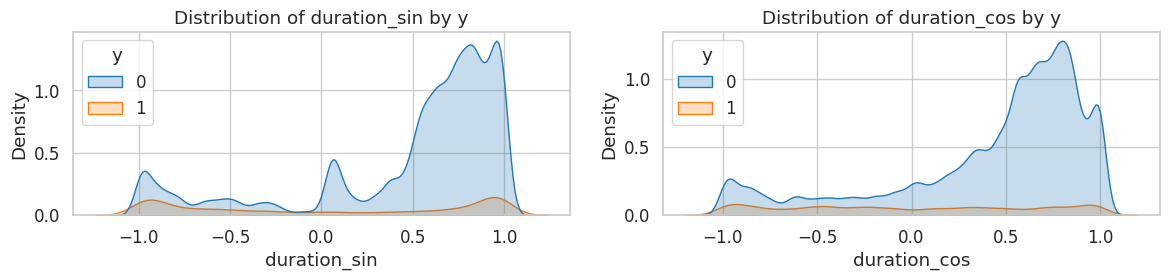

In [ ]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
sns.kdeplot(data=train, x='duration_sin', hue='y', fill=True, palette={0:'#1f77b4', 1:'#ff7f0e'})
plt.title('Distribution of duration_sin by y')

plt.subplot(1,2,2)
sns.kdeplot(data=train, x='duration_cos', hue='y', fill=True, palette={0:'#1f77b4', 1:'#ff7f0e'})
plt.title('Distribution of duration_cos by y')

plt.tight_layout()
plt.show()

### Target Encoding

This cell implements target encoding for categorical features. It uses an auxiliary dataset (`bank-full.csv`) to calculate the mean of the target variable (`y`) for each category of the specified columns. This helps in:

*   **Converting Categorical to Numerical**: Replacing high-cardinality categorical features with numerical representations based on their relationship with the target variable.
*   **Reducing Dimensionality**: Avoiding the creation of many new columns (as with one-hot encoding), which is beneficial for tree-based models.
*   **Handling Unseen Categories**: Filling missing values and categories not present in the original dataset with the overall mean target value.

Categorical Feature Combination

`jobedu = job + '' + education`

• Tree models can split on job or education separately, but rarely discover interactions like “blue-collar + primary” vs. “management + university” on their own.

• Manually concatenating the two categories gives the model an explicit second-order interaction; LightGBM can exploit this with a single split.

• The trade-off is a higher cardinality, so frequency / target encoding (see next steps) is essential to prevent overfitting.

In [ ]:
original = pd.read_csv('bank-full.csv', sep=';')
original['y'] = original['y'].map({'no': 0, 'yes':1})

cat_cols = ['job','marital', "education", 'contact', 'poutcome','month','default','housing','loan','job_edu']

mean = train['y'].mean()

for c in COLS:
  new_col = f"{c}_mean_target_orig"
  train[new_col] = train[c].map(original.groupby(c)['y'].mean())
  train[new_col] = train[new_col].fillna(mean)
  test[new_col] = test[c].map(original.groupby(c)['y'].mean())
  test[new_col] = test[new_col].fillna(mean)

### Categorical Type Conversion

This step converts specified categorical columns to pandas `category` dtype.


• LightGBM and CatBoost can natively handle integer-encoded categories—faster execution and lower memory.

• Prevents scikit-learn pipelines from exploding them into a huge sparse one-hot matrix.

• Keeps missing-value and unseen-category handling consistent with library defaults.

In [ ]:
def update(df):

    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

train = update(train)
test = update(test)

train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,housing_mean_target_orig,loan_mean_target_orig,contact_mean_target_orig,day_mean_target_orig,month_mean_target_orig,duration_mean_target_orig,campaign_mean_target_orig,pdays_mean_target_orig,previous_mean_target_orig,poutcome_mean_target_orig
id,,,,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,...,0.167024,0.126557,0.149189,0.158333,0.110133,0.033333,0.111936,0.091573,0.091573,0.091615
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,...,0.167024,0.126557,0.040707,0.098787,0.102228,0.086331,0.145976,0.091573,0.091573,0.091615
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,...,0.077000,0.126557,0.040707,0.113636,0.067195,0.012048,0.112035,0.091573,0.091573,0.091615
3,27,student,single,secondary,no,34,yes,no,unknown,28,...,0.077000,0.126557,0.040707,0.078142,0.067195,0.000000,0.112035,0.091573,0.091573,0.091615
4,26,technician,married,secondary,no,889,yes,no,cellular,3,...,0.077000,0.126557,0.149189,0.164968,0.166478,0.500000,0.145976,0.091573,0.091573,0.091615


In [ ]:
for col in df.columns:
    if (df[col] == 'unknown').any():
        print(f"Column '{col}': {(df[col] == 'unknown').sum()} 'unknown' values")

Column 'job': 2917 'unknown' values
Column 'education': 21299 'unknown' values
Column 'contact': 231627 'unknown' values
Column 'poutcome': 672450 'unknown' values


In [ ]:
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.preprocessing import OrdinalEncoder

# Re-initialize X to ensure we are working with the original dataframe before encoding
y = df['y']
X = df.drop('y', axis=1)

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply OrdinalEncoder to categorical columns and update X
enc = OrdinalEncoder()
X[categorical_cols] = enc.fit_transform(X[categorical_cols])

# Feature selection
estimator = LinearSVC(penalty='l2', dual=False, random_state=42) # Added dual=False as n_samples > n_features
selector = RFE(estimator, n_features_to_select=9, step=1)
selector = selector.fit(X, y)
selector.ranking_

array([5, 3, 1, 1, 1, 8, 1, 1, 1, 4, 1, 6, 1, 7, 1, 2])

In [ ]:
selector.get_feature_names_out()

array(['marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'campaign', 'previous'], dtype=object)

In [ ]:
df_fromModel = df.copy()

y_fromModel = df_fromModel['y']
X_fromModel = df_fromModel.drop('y', axis=1)

categorical_cols = X_fromModel.select_dtypes(include=['object']).columns
X_fromModel[categorical_cols] = enc.fit_transform(X_fromModel[categorical_cols])

select_Model = SelectFromModel(estimator=LinearSVC(penalty="l2", C=5.4)).fit(X_fromModel, y_fromModel)
select_Model.threshold_, select_Model.get_feature_names_out()

(np.float64(0.06641159106432415),
 array(['marital', 'housing', 'loan', 'contact', 'poutcome'], dtype=object))

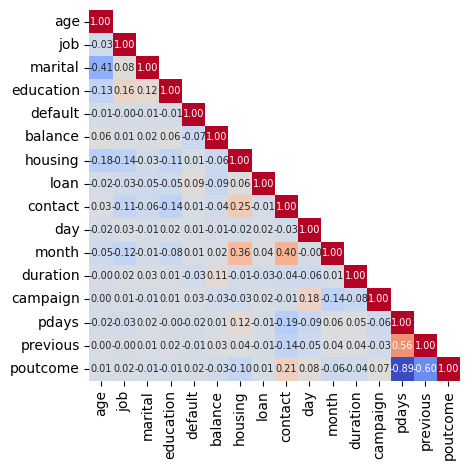

In [ ]:
corr_X = X.corr()
mask_X = np.triu(np.ones_like(corr_X, dtype=bool), k=1)

corr_X_fromModel = X_fromModel.corr()
mask_X_fromModel = np.triu(np.ones_like(corr_X_fromModel, dtype=bool), k=1)

sns.heatmap(
    data=corr_X,
    annot=True,
    fmt='.2f',
    mask=mask_X,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 7},
    cbar=False
)

plt.tight_layout()
plt.show()

The same thing can be observed in either cases, so any of them can be used from going forward

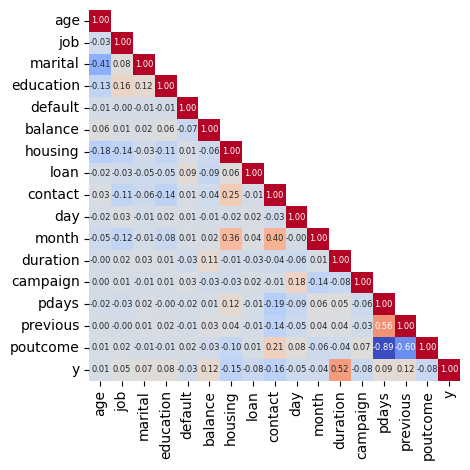

In [ ]:
merged_from_model = pd.concat([X_fromModel, y_fromModel], axis=1)

corr_merged_from_model = merged_from_model.corr()
masked_corr_merged_from_model = np.triu(np.ones_like(corr_merged_from_model, dtype=bool), k=1)

sns.heatmap(
    data=corr_merged_from_model,
    annot=True,
    fmt='.2f',
    mask=masked_corr_merged_from_model,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 6},
    cbar=False
)

plt.tight_layout()
plt.show()

### Model Training Setup with Stratified K-Fold and Target Encoding (`1GWluXqew6YT`)

This cell sets up a robust training pipeline using `StratifiedKFold` for cross-validation and `TargetEncoder` for categorical feature transformation, specifically for the Gradient Boosting Classifier. While the execution of this cell was interrupted, its purpose is to:

*   **Cross-Validation**: Split the data into multiple folds, ensuring that the proportion of target classes is maintained in each fold (`StratifiedKFold`). This provides a more reliable estimate of model performance.
*   **Target Encoding within Folds**: Apply `TargetEncoder` *within* each fold's training data and then transform the validation data. This prevents data leakage, where information from the validation set could implicitly influence the encoding.
*   **Class Weighting**: Calculate and apply sample weights to address class imbalance, giving more importance to the minority class during training.
*   **Gradient Boosting Classifier**: Initialize and train a `GradientBoostingClassifier` with predefined hyperparameters on the target-encoded and weighted training data.

In [ ]:
gbc = {
    "loss": 'log_loss',
    "learning_rate": 0.059470106326462845,
    "n_estimators": 30,
    "subsample": 0.8998572552011879, # the higher the value, the higher the bias
    "min_samples_split": 19, # restricts the growth of individual trees, making them less complex and shallower; high number increases bias
    "min_samples_leaf": 13, # prunes the tree, making it simpler if the number is high (more bias)
    "max_depth": 47,
    "min_impurity_decrease": 0.16644024948325548, # high value requires a substantial improvement in impurity reduction for a split to occur
    "max_leaf_nodes": 211,
    "random_state": 42,
    "verbose": 1,
}
mlp_class = {
    "hidden_layer_sizes":(128,),
    "alpha":0.001,
    "learning_rate":'adaptive',
    "learning_rate_init":0.001,
    "max_iter":50,
    "shuffle":True,
    "random_state":42,
    "tol":0.0001,
    "verbose":1,
    "validation_fraction":0.1,
}

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# df_stratify = df.copy()
y = train['y']
X = train.drop('y', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Calculate class weights based on y_train for handling imbalance
class_counts = y_train.value_counts()
weight_for_0 = 1.0 / class_counts[0]
weight_for_1 = 1.0 / class_counts[1]

sample_weights = np.array([weight_for_0 if label == 0 else weight_for_1 for label in y_train])

# Normalize weights so they sum to the number of samples
sample_weights = sample_weights * (len(y_train) / sample_weights.sum())

In [ ]:
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns

fold_scores = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
  print(f"### Working on Fold {fold + 1}... ###")

  X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
  y_train, y_val= y.iloc[train_idx], y.iloc[val_idx]

  class_counts = y_train.value_counts()
  weight_for_0 = 1.0 / class_counts[0]
  weight_for_1 = 1.0 / class_counts[1]

  sample_weights = np.array([weight_for_0 if label == 0 else weight_for_1 for label in y_train])

  print(f"Target encoding {len(categorical_cols)} features... ", end="")
  for i, c in enumerate(categorical_cols):
    target_encoder = TargetEncoder(cv=8, random_state=42)
    X_train[c] = target_encoder.fit_transform(X_train.loc[:, [c]], y_train)
    X_val[c] = target_encoder.transform(X_val.loc[:, [c]])

  GBClassifier = GradientBoostingClassifier(**gbc)
  GBClassifier.fit(X_train, y_train, sample_weight=sample_weights)
  y_predictions = GBClassifier.predict(X_val)

  roc_auc_score_val = roc_auc_score(y_val, y_predictions)
  fold_scores[f"ROC AUC score for Fold {fold + 1}"] = roc_auc_score_val
  print("ROC AUC score for this Fold: ", roc_auc_score_val)

print(fold_scores)

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

GBClassifier = GradientBoostingClassifier(**gbc)

# Calculate class weights based on y_train for handling imbalance
class_counts = y_train.value_counts()
weight_for_0 = 1.0 / class_counts[0]
weight_for_1 = 1.0 / class_counts[1]

sample_weights = np.array([weight_for_0 if label == 0 else weight_for_1 for label in y_train])

GBClassifier.fit(X_train, y_train, sample_weight=sample_weights)
y_predictions = GBClassifier.predict(X_val)

roc_auc_score_val = roc_auc_score(y_val, y_predictions)
print(f"ROC AUC Score: {roc_auc_score_val}")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3072           0.0791            4.09m
         2           1.2367           0.0703            3.56m
         3           1.1737           0.0629            3.21m
         4           1.1175           0.0561            2.96m
         5           1.0668           0.0512            3.01m
         6           1.0207           0.0460            2.97m
         7           0.9790           0.0427            2.82m
         8           0.9405           0.0345            2.74m
         9           0.9060           0.0378            2.68m
        10           0.8740           0.0308            2.58m
        20           0.6651           0.0175            1.76m
        30           0.5661           0.0165            1.15m
        40           0.5118           0.0048           33.97s
        50           0.4793          -0.0035            0.00s
ROC AUC Score: 0.9031140988525774


In [ ]:
import sklearn.svm
import optuna

def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', 'gbc')
    subsample = trial.suggest_float('subsample', 0.3, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    max_depth = trial.suggest_int('max_depth', 30, 70)
    min_samples_split = trial.suggest_int('min_samples_split', 7, 27)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.005, 0.2)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 200, 250)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    regressor_obj = GradientBoostingClassifier(
        subsample= subsample,
        learning_rate= learning_rate,
        max_depth= max_depth,
        min_samples_split= min_samples_split,
        min_impurity_decrease= min_impurity_decrease,
        max_leaf_nodes= max_leaf_nodes,
        min_samples_leaf= min_samples_leaf,
        random_state= 42,
        n_estimators=50,
        verbose=1,
    )

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_val)

    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=75)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

### MLP Classifier Training and Evaluation (`u9mjasJzK92U`, `IbLM18tiitO5`)

These cells train and evaluate a Multilayer Perceptron (MLP) Classifier:

*   **MLP Training**: An `MLPClassifier` (a type of neural network) is initialized with specific hyperparameters (`mlp_class`) and trained on the `X_train` and `y_train` datasets.
*   **Evaluation**: The trained `mlp` model's performance is then evaluated on the validation set (`X_val`, `y_val`). This includes calculating:
    *   **Predicted Probabilities**: `mlp.predict_proba` gives the probability of each class.
    *   **Predicted Labels**: `mlp.predict` gives the final class prediction.
    *   **Accuracy Score**: `mlp.score` provides the overall accuracy.
    *   **ROC-AUC Score**: `roc_auc_score` measures the model's ability to distinguish between classes, which is particularly useful for imbalanced datasets.

In [ ]:
mlp = MLPClassifier(**mlp_class).fit(X_train, y_train)

Iteration 1, loss = 0.51040627
Iteration 2, loss = 0.45442460
Iteration 3, loss = 0.44158597
Iteration 4, loss = 0.41314096
Iteration 5, loss = 0.42341084
Iteration 6, loss = 0.37105064
Iteration 7, loss = 0.34885873
Iteration 8, loss = 0.33773104
Iteration 9, loss = 0.35833407
Iteration 10, loss = 0.32674756
Iteration 11, loss = 0.31098145
Iteration 12, loss = 0.31307064
Iteration 13, loss = 0.29673379
Iteration 14, loss = 0.30144323
Iteration 15, loss = 0.30078237
Iteration 16, loss = 0.28301416
Iteration 17, loss = 0.28108035
Iteration 18, loss = 0.27762694
Iteration 19, loss = 0.26630729
Iteration 20, loss = 0.26143875
Iteration 21, loss = 0.24969001
Iteration 22, loss = 0.24775029
Iteration 23, loss = 0.24422892
Iteration 24, loss = 0.23714677
Iteration 25, loss = 0.23054278
Iteration 26, loss = 0.22295247
Iteration 27, loss = 0.22080917
Iteration 28, loss = 0.21294656
Iteration 29, loss = 0.20885110
Iteration 30, loss = 0.20734946
Iteration 31, loss = 0.20154325
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities and labels on the validation set (X_val)
y_val_proba = mlp.predict_proba(X_val)
y_val_pred = mlp.predict(X_val)

# Calculate accuracy score on the validation set
y_val_score = mlp.score(X_val, y_val)

# Calculate ROC-AUC score on the validation set
# Use probabilities for ROC AUC, specifically the probability of the positive class
mlp_roc_auc = roc_auc_score(y_val, y_val_proba[:, 1])

print('Predicted probabilities of MLP on the validation dataset (first 5 samples): ', y_val_proba[:5])
print('Predicted labels of MLP on the validation dataset (first 5 samples): ', y_val_pred[:5])
print('Accuracy on the validation dataset: ', y_val_score)
print('ROC-AUC on the validation dataset: ', mlp_roc_auc)

Predicted probabilities of MLP on the validation dataset (first 5 samples):  [[0.99403928 0.00596072]
 [0.23306987 0.76693013]
 [0.99856155 0.00143845]
 [0.99271184 0.00728816]
 [0.9592014  0.0407986 ]]
Predicted labels of MLP on the validation dataset (first 5 samples):  [0 1 0 0 0]
Accuracy on the validation dataset:  0.91664
ROC-AUC on the validation dataset:  0.9438232541183075


### Gradio Prediction Interface (`3256a5ae`)

This cell creates an interactive web interface using `Gradio` to demonstrate the `MLPClassifier` model's predictions:

*   **`predict_customer_response` function**: This function takes user inputs for various customer attributes, transforms them into the format expected by the `mlp` model (including ordinal encoding of categorical features), and then uses the model to predict the probability of subscribing to a term deposit.
*   **`input_components`**: Defines interactive input elements (sliders, dropdowns) for each feature, pre-populated with data from the original DataFrame and categorical mappings.
*   **`output_components`**: Specifies where the prediction result and confidence scores will be displayed.
*   **`gr.Interface`**: Combines the input, output, and prediction function to create the Gradio application, allowing users to interact with the trained model and see real-time predictions.

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np

# Assuming mlp model, X, df, enc, categorical_cols are already defined and available from previous cells.
# Re-create a mapping for original string categories to their ordinal encoded values
categorical_mappings = {}
for i, col_name in enumerate(categorical_cols):
    categorical_mappings[col_name] = {category: j for j, category in enumerate(enc.categories_[i])}

def predict_customer_response(
    age, job_str, marital_str, education_str, default_str, balance, housing_str, loan_str,
    contact_str, day, month_str, duration, campaign, pdays, previous, poutcome_str
):
    # Create a dictionary of input values
    input_dict = {
        'age': age,
        'job': job_str,
        'marital': marital_str,
        'education': education_str,
        'default': default_str,
        'balance': balance,
        'housing': housing_str,
        'loan': loan_str,
        'contact': contact_str,
        'day': day,
        'month': month_str,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'poutcome': poutcome_str
    }

    # Create a DataFrame from the input dictionary, ensuring column order matches X
    input_df = pd.DataFrame([input_dict], columns=X.columns)

    # Encode categorical features using the pre-fitted encoder
    for col in categorical_cols:
        # Use .map() to apply the ordinal encoding
        input_df[col] = input_df[col].map(categorical_mappings[col])
        # Handle cases where a category might not be in the original training data (e.g., if user types something not in dropdown)
        # For dropdowns, this is less of an issue, but for robustness, we could replace NaNs with a default or raise an error.
        # For this example, assuming valid inputs due to dropdowns.

    # Ensure all columns are numeric before prediction
    input_df = input_df.apply(pd.to_numeric, errors='coerce')

    # Make prediction
    prediction_proba = mlp.predict_proba(input_df)[0]
    prediction_label = mlp.predict(input_df)[0]

    # Interpret prediction
    result = "Will Subscribe to Term Deposit" if prediction_label == 1 else "Will NOT Subscribe to Term Deposit"
    confidence_class_0 = prediction_proba[0] * 100
    confidence_class_1 = prediction_proba[1] * 100

    return result, f"{confidence_class_0:.2f}%", f"{confidence_class_1:.2f}%"

# Gradio Interface setup
input_components = [
    gr.Slider(minimum=int(df['age'].min()), maximum=int(df['age'].max()), step=1, value=int(df['age'].mean()), label='Age'),
    gr.Dropdown(list(categorical_mappings['job'].keys()), label='Job'),
    gr.Dropdown(list(categorical_mappings['marital'].keys()), label='Marital Status'),
    gr.Dropdown(list(categorical_mappings['education'].keys()), label='Education'),
    gr.Dropdown(list(categorical_mappings['default'].keys()), label='Default (Has Credit in Default?)'),
    gr.Number(value=float(df['balance'].mean()), label='Balance'),
    gr.Dropdown(list(categorical_mappings['housing'].keys()), label='Housing Loan (Has Housing Loan?)'),
    gr.Dropdown(list(categorical_mappings['loan'].keys()), label='Personal Loan (Has Personal Loan?)'),
    gr.Dropdown(list(categorical_mappings['contact'].keys()), label='Contact Method'),
    gr.Slider(minimum=int(df['day'].min()), maximum=int(df['day'].max()), step=1, value=int(df['day'].mean()), label='Day of Month'),
    gr.Dropdown(list(categorical_mappings['month'].keys()), label='Last Contact Month'),
    gr.Slider(minimum=int(df['duration'].min()), maximum=int(df['duration'].max()), step=1, value=int(df['duration'].mean()), label='Last Contact Duration (seconds)'),
    gr.Slider(minimum=int(df['campaign'].min()), maximum=int(df['campaign'].max()), step=1, value=int(df['campaign'].mean()), label='Number of Contacts During Current Campaign'),
    gr.Slider(minimum=int(df['pdays'].min()), maximum=int(df['pdays'].max()), step=1, value=int(df['pdays'].mean()), label='Days Since Last Contact From Previous Campaign'),
    gr.Slider(minimum=int(df['previous'].min()), maximum=int(df['previous'].max()), step=1, value=int(df['previous'].mean()), label='Number of Contacts Before Current Campaign'),
    gr.Dropdown(list(categorical_mappings['poutcome'].keys()), label='Outcome of Previous Campaign')
]

output_components = [
    gr.Textbox(label="Prediction"),
    gr.Textbox(label="Confidence (Class 0 - No Subscription)"),
    gr.Textbox(label="Confidence (Class 1 - Will Subscribe)")
]

iface = gr.Interface(
    fn=predict_customer_response,
    inputs=input_components,
    outputs=output_components,
    title="MLPClassifier Bank Term Deposit Prediction",
    description="Enter customer details to predict whether they will subscribe to a term deposit. <br><b>Note:</b> The 'Last Contact Duration (seconds)' feature is highly predictive but is typically only known *after* a call is made. Use with caution for real-time predictions where this information is not yet available."
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c45c00542b6acd57c3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
